# Library Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import random


# Item Selection

I selected all the assets that had data from 2008-01-01 among the S&P500 stock list.

In [12]:
#path = 'C:/Users/Froilan/Desktop/myFiles/JupyterFiles/stock_correlation_prediction/stock_data'
path = 'C:\\Users\\prana\\Documents\\DS 340W\\Data'
stock08 = []
for file in os.listdir(path):
    file_path = path + '/' + file
    date = pd.read_csv(file_path)['Date']
    #if len(date)>0 and pd.read_csv(file_path)['Date'][0] <= '2008-01-01' :
    stock08.append(file)
print(str(len(stock08))+" stocks selected")
print(stock08)

2 stocks selected
['AAPL.csv', 'AMZN.csv']


# Organize Data

In order to keep concise and deal with missing data, I concatenated all the price data of the selected items above to a single dataframe

In [18]:
stock_price_dict = {}

for file in stock08 :
    path = 'C:\\Users\\prana\\Documents\\DS 340W\\Data\\' + file
    df = pd.read_csv(path)
    df = df[df.Date >= '2014-12-17']
    pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    stock_price_dict[file.split(".")[0]] = df['Close']

market_path = "C:\\Users\\prana\\Documents\\DS 340W\\SP500_index.csv"
df = pd.read_csv(market_path)
df = df[df.Date >= '2014-12-17']
pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index(pd.DatetimeIndex(df['Date']))
stock_price_dict['SP500'] = df['Close']
    
stock_price_df = pd.DataFrame(stock_price_dict)

In [19]:
print(stock_price_df.head())

                 AAPL     AMZN        SP500
Date                                       
2014-12-17  27.352501  14.9440  2012.890015
2014-12-18  28.162500  14.8865  2061.229980
2014-12-19  27.945000  14.9950  2070.649902
2014-12-22  28.235001  15.3270  2078.540039
2014-12-23  28.135000  15.3145  2082.169922


# Dealing with Missing Data

In [21]:
NA_col = []
NA_ratio = []
for col in stock_price_df.columns :
    na_index = np.where(stock_price_df[col].isnull())[0]
    NA_col.append(col)
    NA_ratio.append(len(na_index)/stock_price_df.shape[0] * 100)
    print(col,na_index)
NA_df = pd.DataFrame({'tickers':NA_col,'NA_ratio':NA_ratio})


AAPL []
AMZN []
SP500 [ 765  766  767 ... 1997 1998 1999]


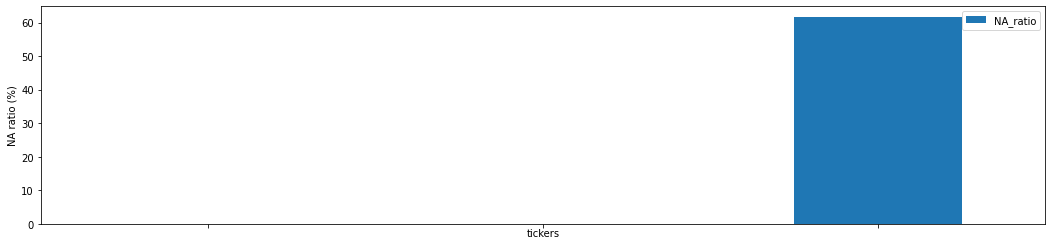

In [22]:
NA_df.plot.bar(rot=0, figsize=(18,4))
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
plt.xlabel('tickers')
plt.ylabel('NA ratio (%)')
plt.show()
plt.close()

Most of the dataset that has missing data has only one or two data points missing. It would be rational enough to impute the data points with the data from the day right before.

However, one company has quite some missing data. 'MMM' is the only company that has high proportion of missing data. Leaving out this one company from the S&P 500 firms wouldn't be a big issue. So I'll drop the 'MMM' column the dataframe

In [23]:
def impute_data(column_name):
    index = stock_price_df.index.values[0]
    price_na_index = np.where(stock_price_df[column_name].isnull())[0]
    for i in price_na_index :
        stock_price_df[column_name][i] = stock_price_df[column_name][i-1]

In [24]:
for item in stock_price_df.columns :
    impute_data(item)

In [25]:
# Final Check for NaN
for item in stock_price_df.columns :
    if stock_price_df[item].isnull().values.any() :
        print('stock price data of '+item+' still has NaN')
print("END OF CHECKING. NO NA REMAINING")

END OF CHECKING. NO NA REMAINING


In [26]:
stock_price_df.to_csv("C:\\Users\\prana\\Documents\\DS 340W\\stock08_price.csv",index_label='Date')

# Create Portfolio

out of 505 companies, 150 firms are randomly selected for the portfolio.

In [27]:
df = pd.read_csv("C:\\Users\\prana\\Documents\\DS 340W\\stock08_price.csv")
universe = list(df.columns.values[1:])
universe.remove("SP500")
print(universe)

['AAPL', 'AMZN']


In [28]:
random.shuffle(universe)
portfolio = universe[:150].copy()

print(portfolio)

['AAPL', 'AMZN']


In [29]:
#FOR LIST REUSE#FOR LIS 
portfolio = ['AAPL', 'AMZN']

# Prepare the Data

In [30]:
def rolling_corr(item1,item2) :
    #import data
    stock_price_df = pd.read_csv("C:\\Users\\prana\\Documents\\DS 340W\\stock08_price.csv")
    pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_pair.columns = [item1,item2]
    df_corr = df_pair[item1].rolling(window=100).corr(df_pair[item2])
    return df_corr


In [62]:
index_list = []
for _ in range(100):
    indices = []
    for k in range(_, 2419,100):
        indices.append(k)
    index_list.append(indices)

data_matrix = []
count = 0
for i in range(1):
    for j in range(1-i):
        a = portfolio[i]
        b = portfolio[1-j]
        file_name = a + '_' + b
            
        corr_series = rolling_corr(a, b)[99:]
        
        for j in range(1):
            corr_strided = list(corr_series[index_list[j]][:20]).copy()
            data_matrix.append(corr_strided)
            count+=1
            if count % 1000 == 0 :
                print(str(count)+' items preprocessed')

data_matrix = np.transpose(data_matrix)
data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame(data_dictionary)
data_df.to_csv("dataset.csv")
